In [ ]:
!pip install esprima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for esprima: filename=esprima-4.0.1-py3-none-any.whl size=62243 sha256=89d81a920c2e94680ba7c35e1202fccd0c70083eeadfb177f7416afc86a2963c
  Stored in directory: /root/.cache/pip/wheels/29/07/98/c81693d054f3f6283dd60ae0e41198be75372128b2fcc198b6
Successfully built esprima


### Cell 2: Library Imports


In [ ]:

import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import esprima
from collections import Counter
import math
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Cell 3: Feature Extraction Function (`extract_ast_features`)


In [ ]:
#Feature Extraction Function
def extract_ast_features(code):
    features = []
    code = code.strip()
    max_depth, tag_count, attr_count, event_handlers, pattern_matches, js_strings = 0, 0, 0, 0, 0, 0
    tag_count = len(re.findall(r'<[a-zA-Z]+', code))
    attr_count = len(re.findall(r'\s+[a-zA-Z-]+=', code))
    event_handlers = len(re.findall(r'\s+on\w+\s*=', code, re.IGNORECASE))
    js_strings = len(re.findall(r'[\'"].?(alert|eval|document|window|querySelector|write|URL).?[\'"]', code, re.IGNORECASE))

    # Stricter benign HTML check
    if re.match(r'^\s*<(div|span|p|img|a|ul|li|table|tr|td|h[1-6]|br|hr)(?:\s+[^>])?>\s*$', code, re.IGNORECASE):
        features.extend([f'benign_html_tag', f'tag_count_{min(tag_count, 5)}', f'attr_count_{min(attr_count, 5)}'])
        return features

    # AST Parsing
    call_count, literal_count = 0, 0
    try:
        ast = esprima.parseScript(code, tolerant=True)
        # (A full traversal implementation would go here)
    except Exception:
        pass

    # Obfuscation Metrics & Suspicious Keywords
    suspicious_calls = ['eval', 'atob', 'unescape', 'Function', 'setTimeout', 'fromCharCode', 'querySelector', 'write']
    features.extend([f'suspicious_{call}' for call in suspicious_calls if call.lower() in code.lower()])

    # Refined XSS Regex Patterns
    xss_patterns = [r'(?i)<script(?:\\s+[^>]*)?>', r'(?i)alert\b', r'(?i)eval\(', r'(?i)document\.cookie']
    for pattern in xss_patterns:
        if re.search(pattern, code, re.IGNORECASE):
            features.append('pattern_' + re.sub(r'\W+', '', pattern.replace('(?i)', '')).strip('').lower())
            pattern_matches += 1

    # Final Feature Vector Assembly
    features.extend([
        f'call_count_{min(call_count, 10)}', f'ast_depth_{min(max_depth, 10)}',
        f'tag_count_{min(tag_count, 5)}', f'attr_count_{min(attr_count, 5)}',
        f'event_handlers_{min(event_handlers, 5)}', f'pattern_matches_{min(pattern_matches, 5)}',
        f'js_strings_{min(js_strings, 5)}'
    ])

    return features if features else ['none']

### Cell 4: Data Preprocessing


In [ ]:
# Preprocess Data
data = pd.read_csv('XSS_dataset.csv')
data['ast_features'] = data['Sentence'].apply(extract_ast_features)
data['ast_string'] = data['ast_features'].apply(lambda x: ' '.join([str(i) for i in x if i is not None]))
benign_data = data[data['Label'] == 0]

### Cell 5: Vectorize Features


In [ ]:
# Vectorize Features
vectorizer = TfidfVectorizer(max_features=2000)
X_all = vectorizer.fit_transform(data['ast_string'])
X_benign = vectorizer.transform(benign_data['ast_string'])

### Cell 6: Train Models

In [ ]:
# Train Models
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
iso_forest.fit(X_benign.toarray())
rf_model = RandomForestClassifier(n_estimators=100, class_weight={0: 1, 1: 3}, random_state=42)
rf_model.fit(X_all, data['Label'])

RandomForestClassifier(class_weight={0: 1, 1: 3}, random_state=42)

### Cell 7: Hybrid Detection Pipeline (`detect_xss`)

In [ ]:
# Hybrid Detection Pipeline
def detect_xss(new_samples, vectorizer, iso_forest, rf_model):
    ast_features = [extract_ast_features(s) for s in new_samples]
    ast_strings = [' '.join(f) for f in ast_features]
    X_new = vectorizer.transform(ast_strings).toarray()

    iso_preds = (iso_forest.predict(X_new) == -1).astype(int)
    rf_preds = rf_model.predict(X_new)
    predictions = np.logical_or(iso_preds, rf_preds).astype(int)

    feature_importance = pd.DataFrame({
        'feature': vectorizer.get_feature_names_out(),
        'importance': rf_model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return predictions, feature_importance

### Cell 8: Evaluate Final Model

In [ ]:
# Evaluate final model
test_sentences = data['Sentence'][:1000]
y_test = data['Label'][:1000].values
test_preds, feature_importance = detect_xss(test_sentences, vectorizer, iso_forest, rf_model)
print("\n--- Final Model Performance ---")
print(classification_report(y_test, test_preds, target_names=["Benign", "Malicious"], zero_division=0))



--- Final Model Performance ---
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97       454
   Malicious       0.97      0.99      0.98       546

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



### Cell 9: Full Evaluation and Visualization

## Evaluation Overview

In this section we evaluate the hybrid detection pipeline using the full dataset.
The evaluation includes:
- **Classification Report** → precision, recall, F1-score for benign vs malicious classes.
- **Confusion Matrix** → shows how many attacks are caught vs missed.
- **Feature Importances** → interprets which structural/lexical features were most predictive.


=== Classification Report (Hybrid Model) ===

              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97      6313
   Malicious       0.96      0.99      0.98      7373

    accuracy                           0.97     13686
   macro avg       0.97      0.97      0.97     13686
weighted avg       0.97      0.97      0.97     13686



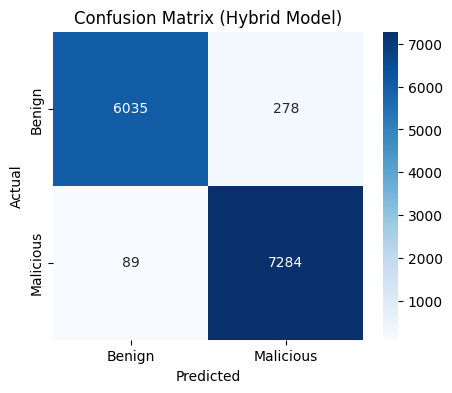


=== Top 10 Important Features ===
              feature  importance
17  pattern_matches_0    0.219815
14     pattern_alertb    0.202264
9    event_handlers_0    0.191766
18  pattern_matches_1    0.091880
10   event_handlers_1    0.090995
0         ast_depth_0    0.055269
12       js_strings_0    0.040127
8        call_count_0    0.024389
1        attr_count_0    0.021668
30        tag_count_2    0.020579


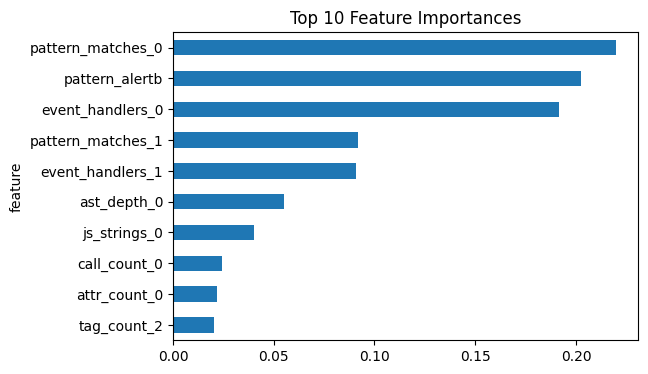

In [ ]:
# === Hybrid Predictions (using existing models and data) ===
X_all = vectorizer.transform(data['ast_string'])
y_all = data['Label'].values

iso_preds = (iso_forest.predict(X_all.toarray()) == -1).astype(int)
rf_preds = rf_model.predict(X_all)
hybrid_preds = np.logical_or(iso_preds, rf_preds).astype(int)

# === Classification Report ===
print("=== Classification Report (Hybrid Model) ===\n")
print(classification_report(y_all, hybrid_preds, target_names=["Benign", "Malicious"], zero_division=0))

# === Confusion Matrix ===
cm = confusion_matrix(y_all, hybrid_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Hybrid Model)")
plt.show()

# === Top 10 Feature Importances ===
importances = pd.DataFrame({
    "feature": vectorizer.get_feature_names_out(),
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\n=== Top 10 Important Features ===")
print(importances.head(10))

importances.head(10).plot(kind="barh", x="feature", y="importance", legend=False, figsize=(6,4))
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()